In [1]:
from pathlib import Path
import os
_cwd = os.getcwd()
from pathlib import Path
import os
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from visualisations import ModelVisualiser, SynthVecDataVisualiser
from datasets import synth_dataset 
import visualisations
from visualisations import visualise_data, visualise_model

In [2]:
import importlib
importlib.reload(experiments.EvaluationManager)

<module 'experiments.EvaluationManager' from 'C:\\Users\\Giulia\\Study\\projects\\research\\SAE\\experiments\\EvaluationManager.py'>

--- 

# Hybrids

In [5]:
params = {"model_name":"ESAE",
          "model_version":"standardS",
          "data" : "MNIST"}

In [6]:
# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()

configs/models/ESAE/standardS.yaml
ESAE model hanlder loaded.
Loading latest checkpoint at logs\ESAE\standardS_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
           

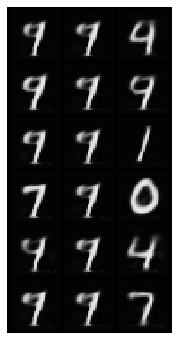

In [7]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_hybrisation=True, do_loss2distortion=False, 
                         do_marginal=False, do_loss2marginal=False, 
                         figsize=(5,6), seed=12)
fig = res['hybrids']
fname = fig_path / ("hybrids"+params["model_name"]+".png")
fig.savefig(fname)


# Distortion

In [6]:
params = {"model_name":"RAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()

configs/models/RAE/standardS.yaml
RAE model hanlder loaded.
Loading latest checkpoint at logs\RAE\standardS_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
             M

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywo

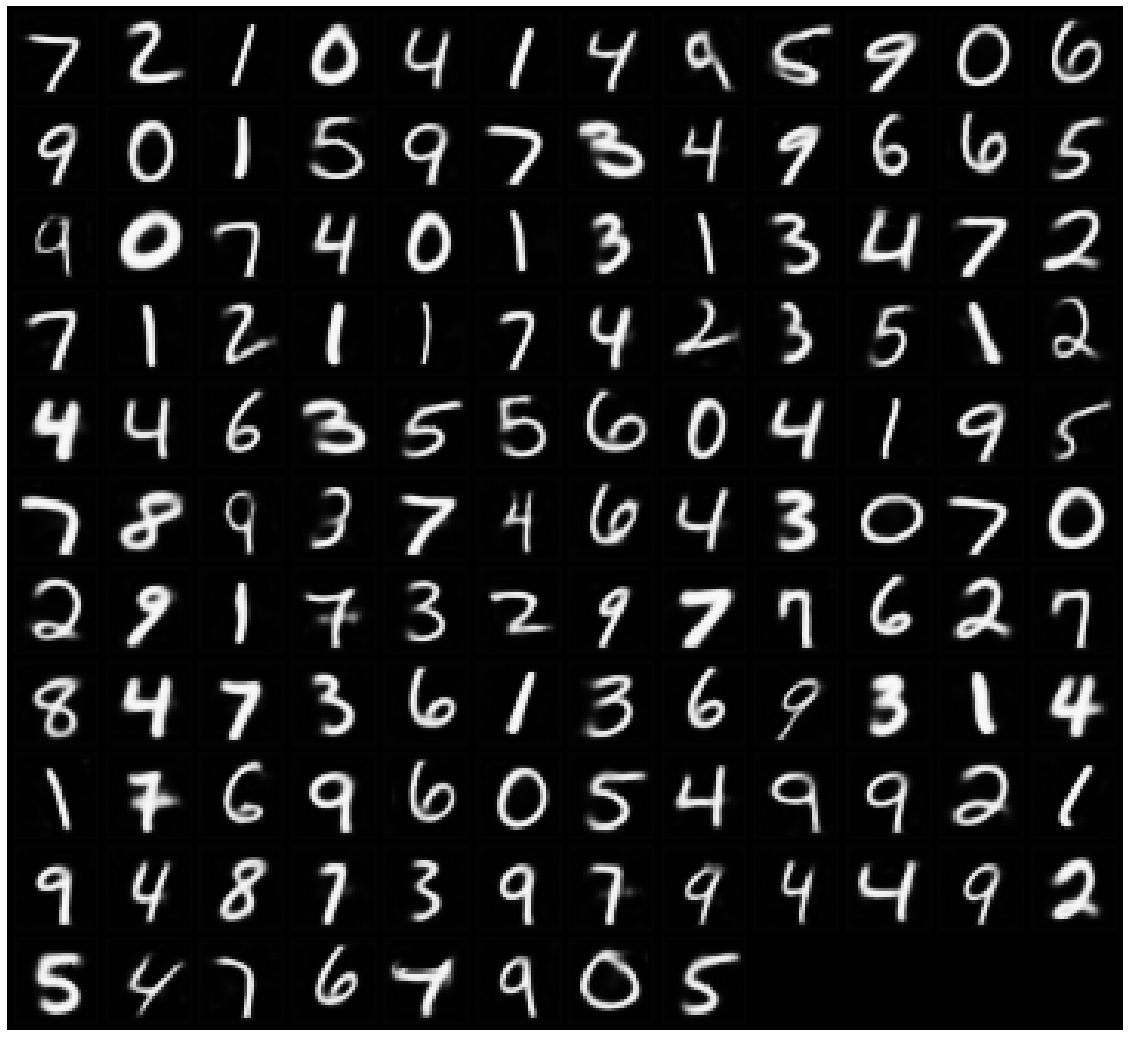

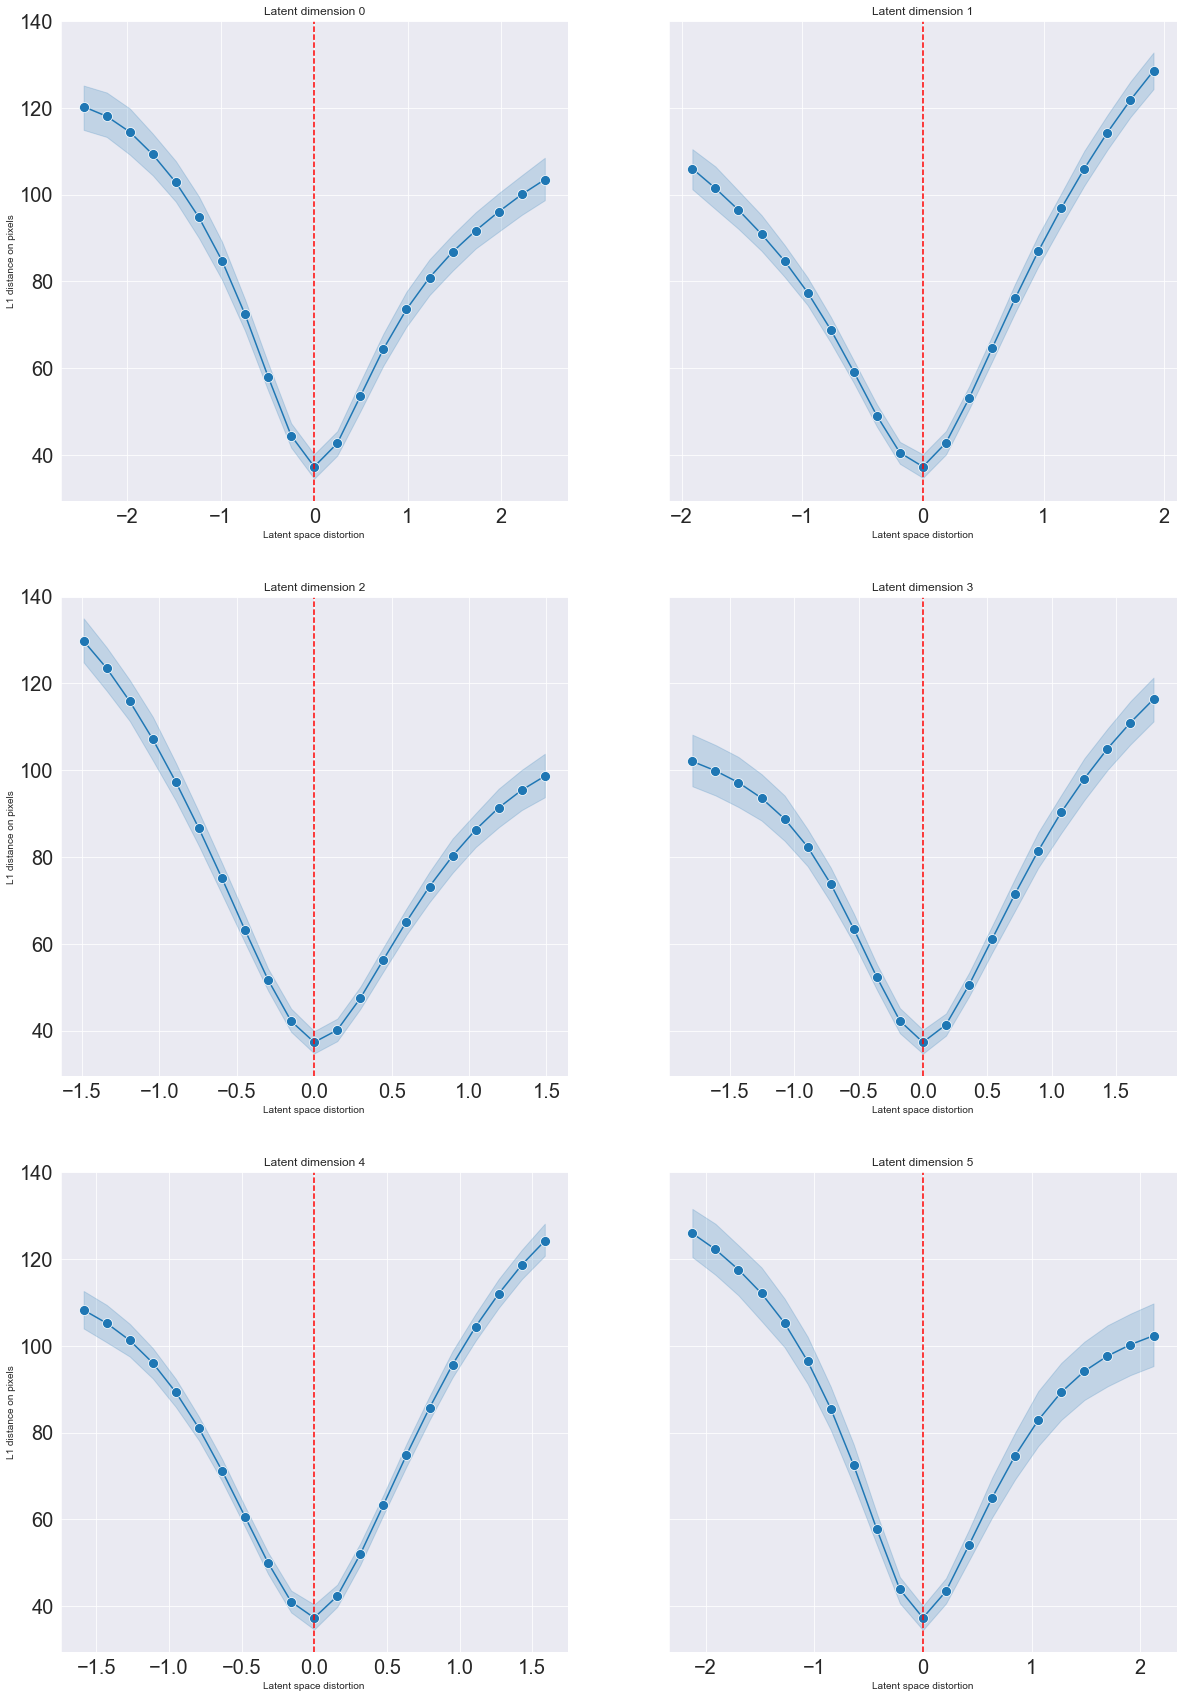

In [9]:
figure_params = {"figsize":(20,30), "nrows":3, "N":100, "x_scale":1.0, "steps":21}

res = handler.plot_model(do_originals=False, do_reconstructions=True,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=True, do_marginal=False, 
                         do_loss2marginal=False, **figure_params)
fig = res['distortion']
fname = fig_path / ("distortion"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywo

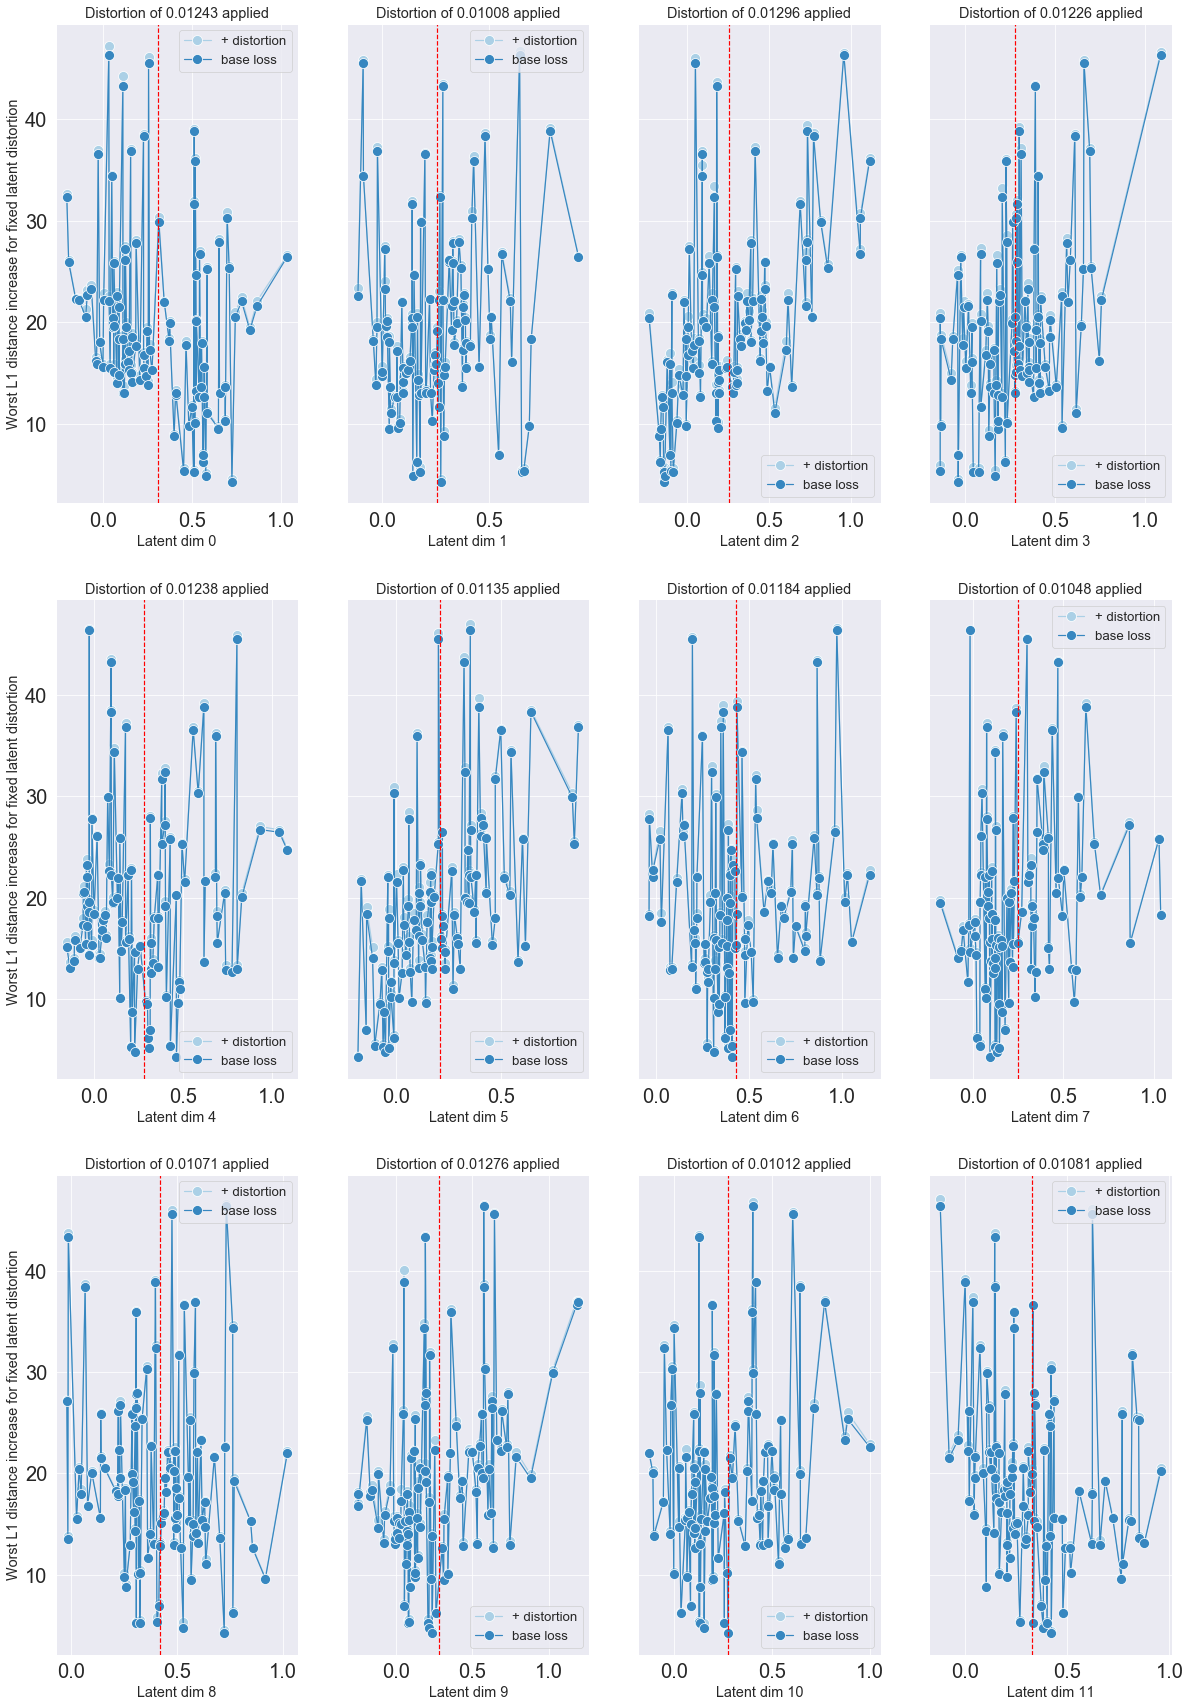

In [14]:
figure_params = {"figsize":(20,30), "nrows":3, "N":100, "relative":False, "ro":0.01}

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=False, do_marginal=False, 
                         do_loss2marginal=True, **figure_params)
fig = res['marginal_distortion']
fname = fig_path / ("marginal_distortion"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

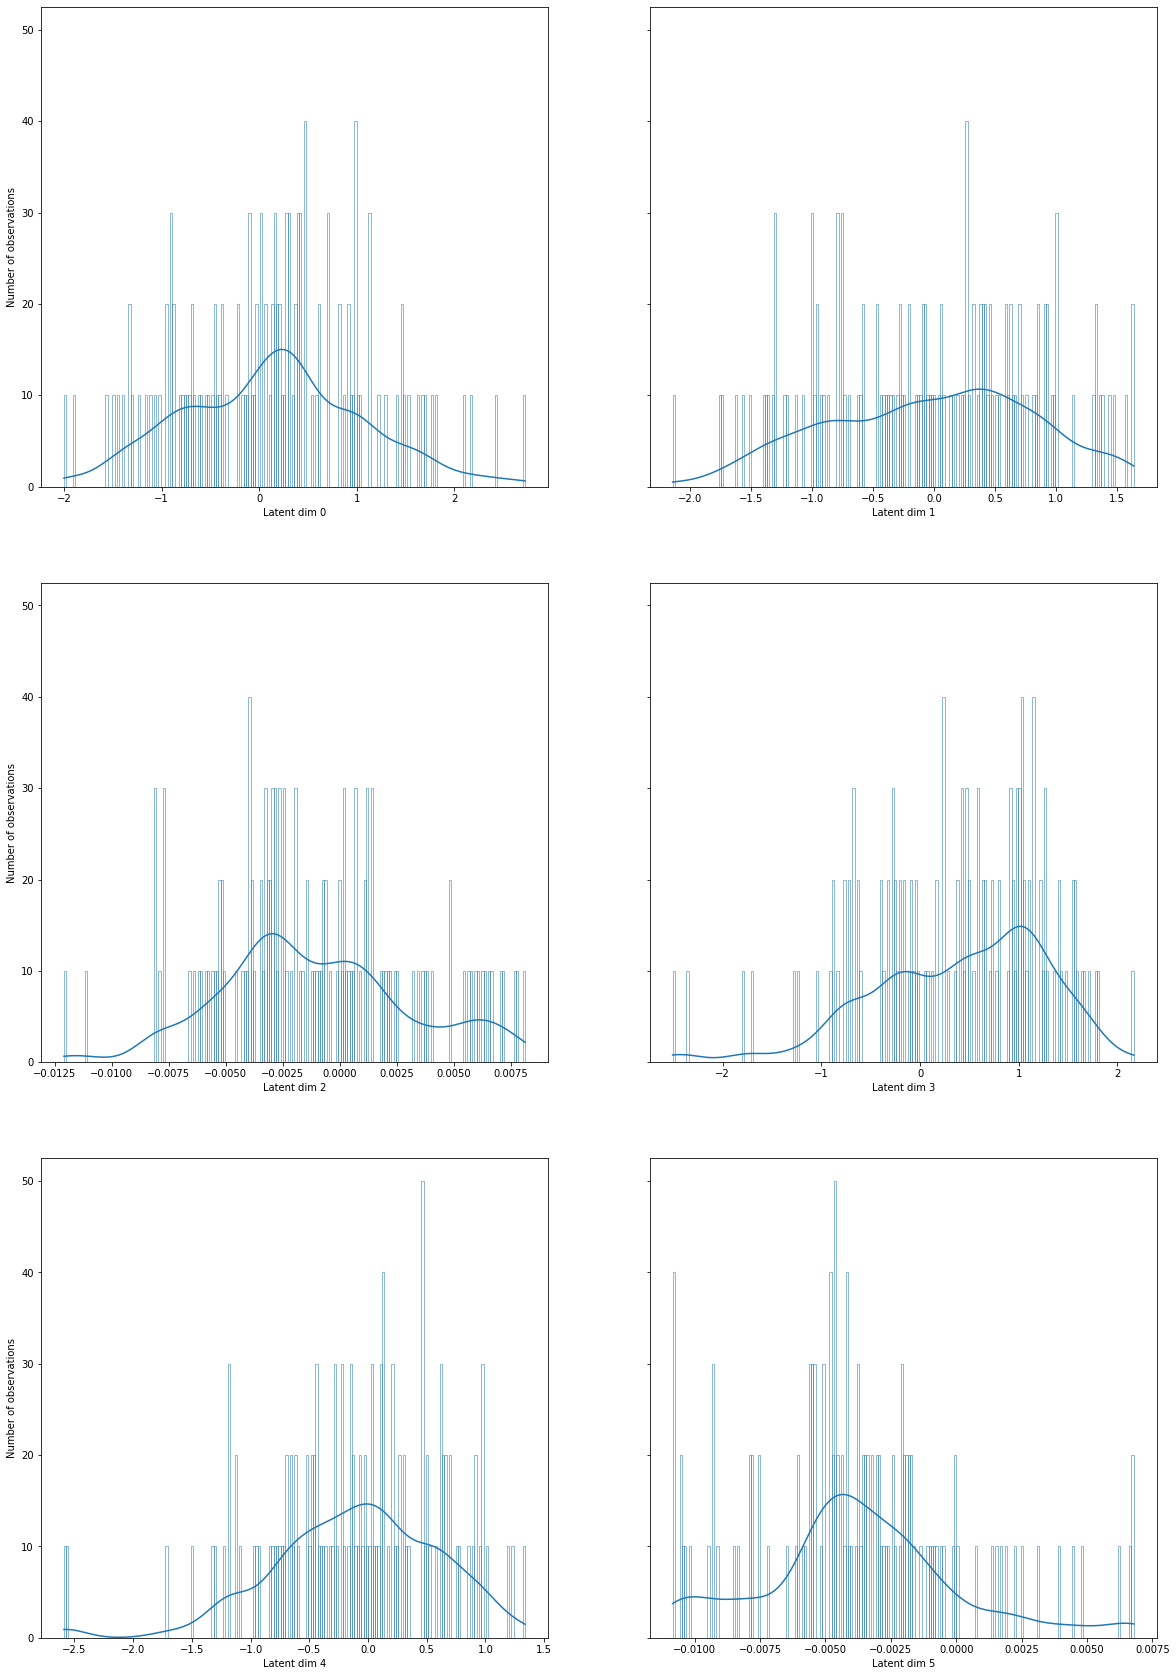

In [5]:
figure_params = {"figsize":(20,30), "nrows":3, "N":100, "markersize":10, "font_scale":10}

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=False, do_marginal=True, 
                         do_loss2marginal=False, **figure_params)
fig = res['marginal']
fname = fig_path / ("marginal"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

# Latent Response

In [2]:
params = {"model_name":"RAE",
          "model_version":"standardS",
          "data_version":"standard",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"

configs/models/RAE/standardS.yaml
RAE model hanlder loaded.


In [3]:
LR = handler.latent_responses(load=True).cpu()

Loading latent response matrix


figures\responsesRAE.png saved


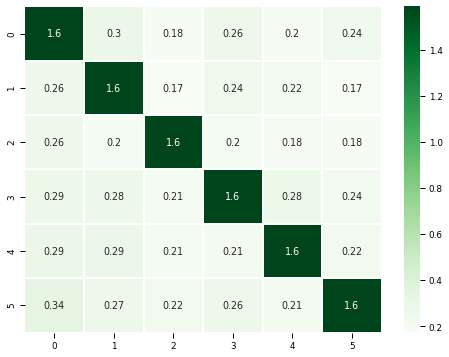

In [4]:
#https://github.com/derekbanas/seaborn/blob/master/SB%20Tut.ipynb
fig = plt.figure(figsize=(8,6))
sns.set_context('paper', font_scale=1.0)
ax = sns.heatmap(LR, linecolor='white', linewidth=1,  cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fname = fig_path / ("responses"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

In [10]:
def draw_graph(matrix, **kwargs):
    """
    kwargs accepted keys: 
    - threshold
    - num_bins (used to discretise the edges weights and assign them colors)
    - figsize
    """
    threshold = kwargs.get('threshold',1.0)
    num_bins = kwargs.get('num_bins',100)
    figsize = kwargs.get('figsize', (8,6))

    graph_adj = torch.max(matrix-threshold,torch.zeros_like(matrix))
    G = nx.from_numpy_matrix(np.matrix(graph_adj), create_using=nx.DiGraph)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [graph_adj[u][v] for u,v in edges]
    weights = np.digitize(weights, np.histogram(weights, num_bins)[1][:-1])
    
    options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": True,
    "font_color": "white",
    }

    fig = plt.figure(figsize=figsize)
    nx.draw(G, pos=pos, **options)
    return fig

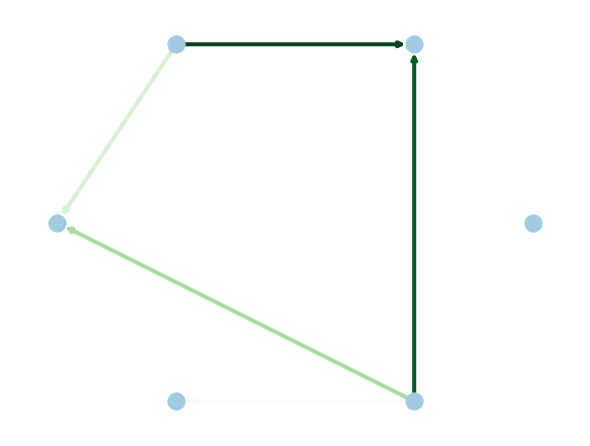

figures\latent_graphBetaVAE.png saved


In [11]:
fig = draw_graph(LR)
plt.show()    
fname = fig_path / ("latent_graph"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

figures\standardVec_graph.png saved


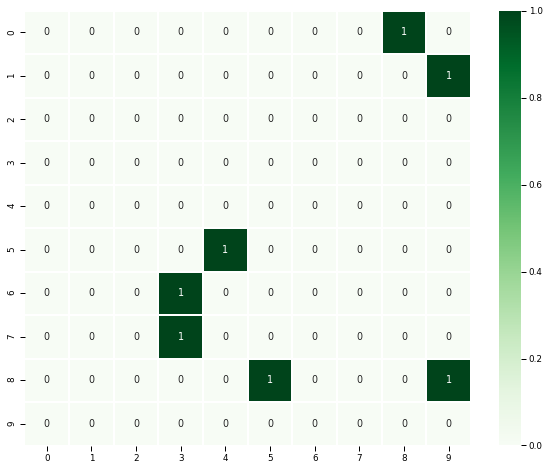

In [21]:
true_matrix = handler.dataloader.train.dataset.dataset.get_graph_matrix()
fig = plt.figure(figsize=(10,8))
sns.set_context('paper', font_scale=1.0)
ax = sns.heatmap(true_matrix, linecolor='white', linewidth=1,  cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fname = fig_path / ("standardVec_graph.png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

--- 

# Drifts

In [2]:
params = {"model_name":"AE",
          "model_version":"standardS",
          "data_version":"standard",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"

configs/models/AE/standardS.yaml
AE model hanlder loaded.


In [3]:
drift_evalutation_params = {
    "num_batches":10,
    "num_interventions":50,
    "num_samples":50,
    "reduce":"mean"}

drift_scorer_params = {
    "random_seed":11,
    "independent":True,
    "verbose":True}

In [4]:
individual_drifts, interventions = handler.evaluate_drift(pairwise=True, **drift_evalutation_params, **drift_scorer_params)

Evaluating individual drifts on latents.
Dimension 0
Sampling values for interventions...
Sampling from interventional_distribution...
Dimension 1
Sampling values for interventions...
Sampling from interventional_distribution...
Dimension 2
Sampling values for interventions...
Sampling from interventional_distribution...
Dimension 3
Sampling values for interventions...
Sampling from interventional_distribution...
Dimension 4
Sampling values for interventions...
Sampling from interventional_distribution...
Dimension 5
Sampling values for interventions...
Sampling from interventional_distribution...
Evaluating pairwise drifts...
Sampling values for interventions...
Sampling from interventional_distribution...
Dimensions 1 and 0
Sampling values for interventions...
Sampling from interventional_distribution...
Sampling values for interventions...
Sampling from interventional_distribution...
Dimensions 2 and 0
Sampling values for interventions...
Sampling from interventional_distribution...

Loading pairwise drift evaluation results


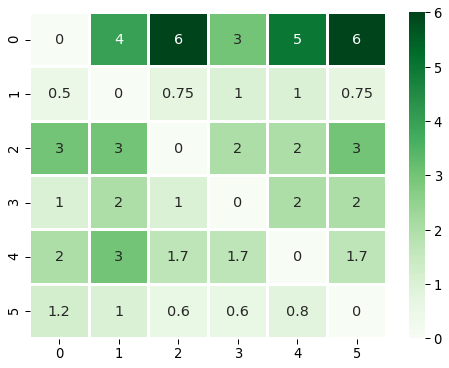

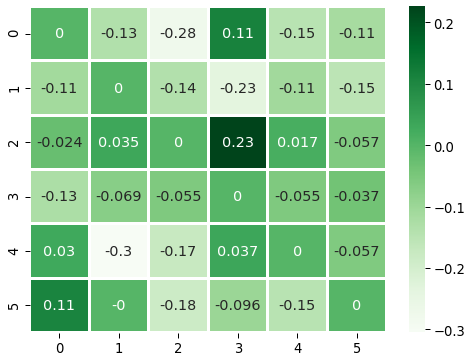

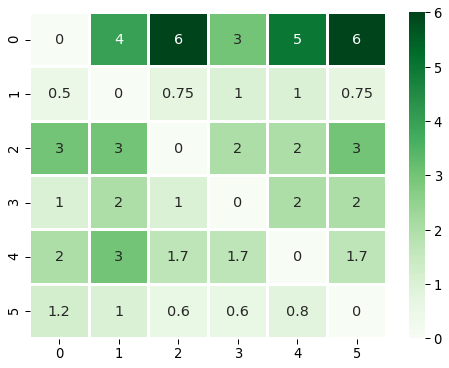

In [6]:
pairwise_drifts, pairwise_effects = handler.load_pairwise_results()
visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
visualiser.plot_heatmap(pairwise_drifts, figsize=(8,6))
visualiser.plot_heatmap(pairwise_effects, figsize=(8,6))

# Causal block

Plotting the adjacency matrix obtained from the masks in the causal latent block of the X-models

In [2]:
params = {"model_name":"XAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()


configs/models/XAE/standardS.yaml


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Loading latest checkpoint at logs\XAE\standardS_MNIST\checkpoints\epoch=143-step=47246.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 

Initialising schedulers Manager...
Explicit mode ON


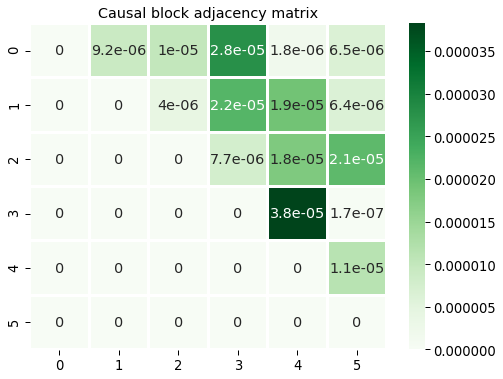

In [3]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,6), "nrows":3, "N":100, "markersize":10, "font_scale":10}
A = handler.causal_block_graph().abs()
#A /= A.max() #normalise
fig = handler.visualiser.plot_heatmap(A.detach().cpu(), 
                                      title="Causal block adjacency matrix", 
                                      threshold=0., 
                                      **figure_params)

In [4]:
fig = draw_graph(A.detach().cpu(), threshold=0.0)
plt.show()    

NameError: name 'draw_graph' is not defined